In [381]:
import detectron2
import numpy as np
import os
import shutil
import torch
import cv2
import random
import json
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper
from detectron2.data import transforms as T
from detectron2.data.datasets import register_coco_instances
from matplotlib import pyplot as plt
from detectron2.data import build_detection_train_loader

%matplotlib inline
setup_logger()

<Logger detectron2 (DEBUG)>

In [382]:
os.makedirs("images", exist_ok=True)
if  len(os.listdir("images")) == 0:
    !curl -L "https://universe.roboflow.com/ds/4tQNhO3ScX?key=vzphVaMKf7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip;
    shutil.move("test", "images/test")
    shutil.move("train", "images/train")
    shutil.move("valid", "images/valid")

In [383]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device.type)
!nvcc --version

Using PyTorch version: 2.6.0  Device: cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


In [384]:
register_coco_instances("trashnet_train", {}, "images/train/_annotations.coco.json", "images/train")
register_coco_instances("trashnet_test", {}, "images/test/_annotations.coco.json", "images/test")
register_coco_instances("trashnet_valid", {}, "images/valid/_annotations.coco.json", "images/valid")
labels =["trash","cardboard","glass","metal","paper", "plastic"]

In [385]:
train_meta = MetadataCatalog.get("trashnet_train")
train_dict = DatasetCatalog.get("trashnet_train")

WARNING [05/03 02:44:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 02:44:41 d2.data.datasets.coco]: Loaded 1757 images in COCO format from images/train/_annotations.coco.json


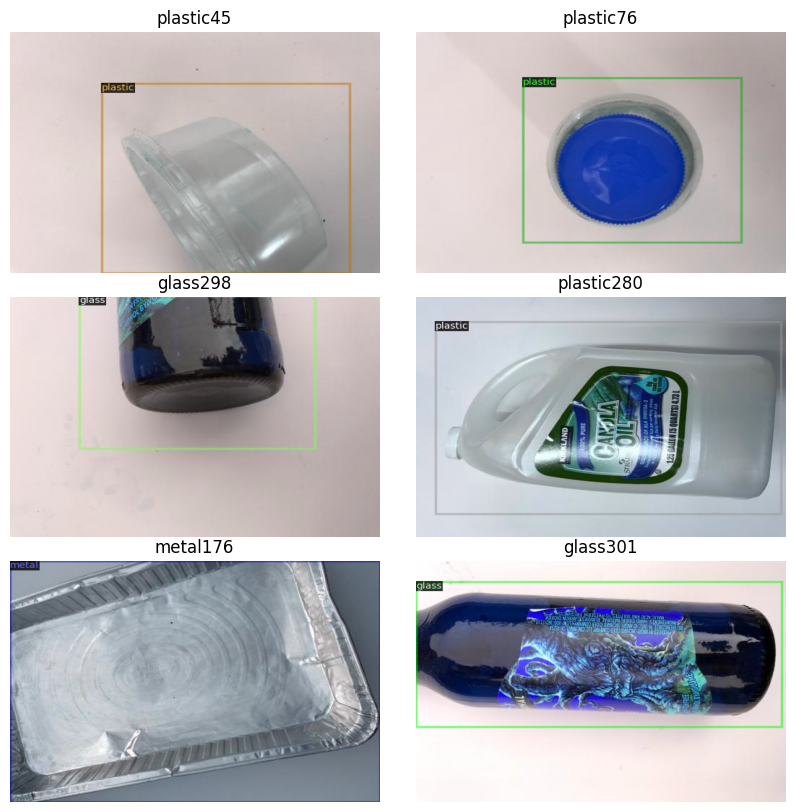

In [386]:
objects = random.sample(train_dict, 6)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
i = 0
for obj in objects:
    img = cv2.imread(obj["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_meta)
    vis = visualizer.draw_dataset_dict(obj)

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(vis.get_image()[:, :, ::-1], aspect="auto")
    axes[row, col].set_title(obj["file_name"].split("_jpg")[0].split("/")[-1])
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [387]:
augs = [
    T.RandomRotation([-15, 15]),
    T.RandomBrightness(0.9, 1.1),
    T.RandomContrast(0.9, 1.1),
    T.RandomSaturation(0.9, 1.1),
    T.RandomLighting(0.1),
    T.RandomFlip(0.5),
    T.RandomFlip(0.5, horizontal=False, vertical=True),
]

class COCOTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    @classmethod
    def build_train_loader(cls, cfg):
        train_mapper = DatasetMapper(
            cfg,
            is_train=True,
            augmentations=augs
        )
        return build_detection_train_loader(
            cfg,
            mapper=train_mapper
        )

train_meta.get("thing_classes", None)

['idk', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [388]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trashnet_train",)
cfg.DATASETS.VALIDATION = ("trashnet_valid",)
cfg.DATASETS.TEST = ("trashnet_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0015
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.DEVICE = device.type
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)

In [389]:
#ONLY if you want training!
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = COCOTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[05/03 02:44:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[05/03 02:44:42 d2.engine.train_loop]: Starting training from iteration 0
[05/03 02:44:45 d2.utils.events]:  eta: 0:12:00  iter: 19  total_loss: 2.282  loss_cls: 2.109  loss_box_reg: 0.1508  loss_rpn_cls: 0.001463  loss_rpn_loc: 0.005054    time: 0.1475  last_time: 0.1301  data_time: 0.0059  last_data_time: 0.0019   lr: 2.9971e-05  max_mem: 3786M
[05/03 02:44:48 d2.utils.events]:  eta: 0:12:06  iter: 39  total_loss: 1.111  loss_cls: 1.012  loss_box_reg: 0.1392  loss_rpn_cls: 0.003537  loss_rpn_loc: 0.004397    time: 0.1477  last_time: 0.1565  data_time: 0.0021  last_data_time: 0.0021   lr: 5.9941e-05  max_mem: 3786M
[05/03 02:44:51 d2.utils.events]:  eta: 0:12:01  iter: 59  total_loss: 0.3451  loss_cls: 0.1984  loss_box_reg: 0.1315  loss_rpn_cls: 0.004232  loss_rpn_loc: 0.003963    time: 0.1471  last_time: 0.1393  data_time: 0.0019  last_data_time: 0.0023   lr: 8.9911e-05  max_mem: 3786M
[05/03 02:44:54 d2.utils.events]:  eta: 0:11:59  iter: 79  total_loss: 0.3059  loss_cls: 0.151  los

In [390]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("trashnet_test", )
predictor = DefaultPredictor(cfg)

[05/03 02:57:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [05/03 02:57:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 02:57:30 d2.data.datasets.coco]: Loaded 264 images in COCO format from images/test/_annotations.coco.json


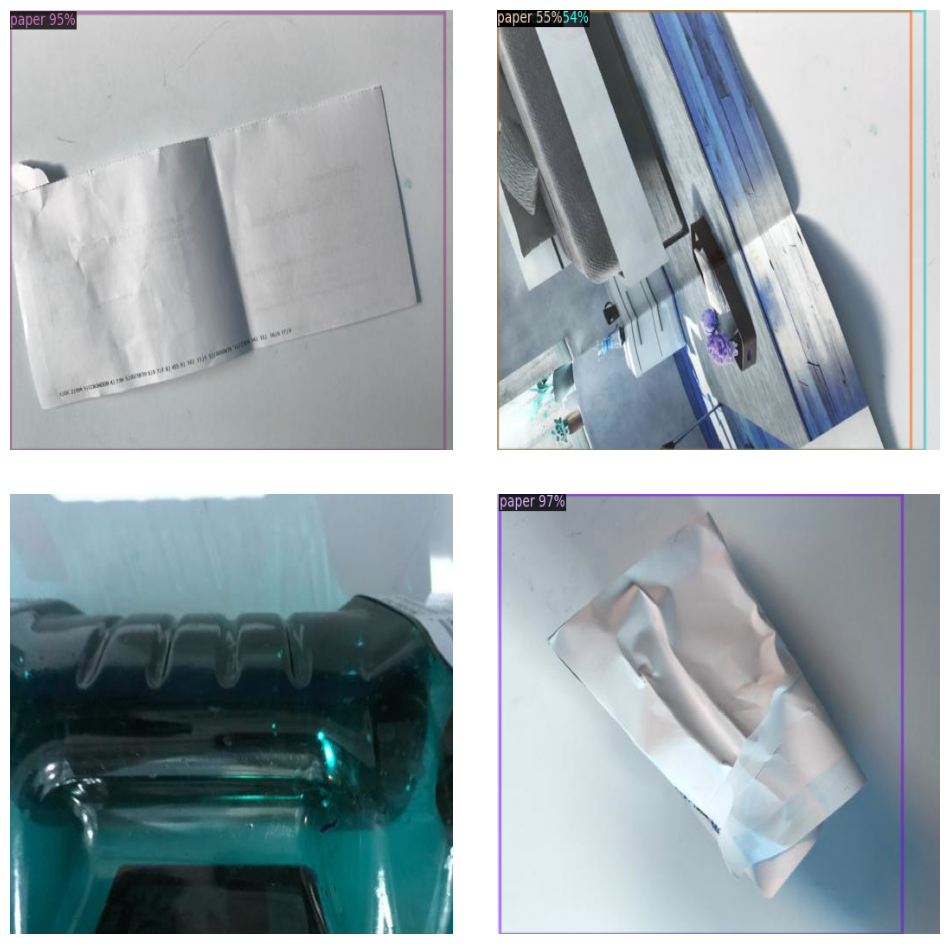

In [391]:
test_metadata = MetadataCatalog.get("trashnet_test")
test_dict = DatasetCatalog.get("trashnet_test")

objects = random.sample(test_dict, 4)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
i = 0

for obj in objects:
    img = cv2.imread(obj["file_name"])
    output = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(output["instances"].to("cpu"))

    row = i // 2
    col = i % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(out.get_image()[:,:,::-1], aspect="auto")
    i += 1

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [392]:
%load_ext tensorboard
%tensorboard --logdir=output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 189134), started 0:24:39 ago. (Use '!kill 189134' to kill it.)

{'instances': Instances(num_instances=1, image_height=1000, image_width=1000, fields=[pred_boxes: Boxes(tensor([[ 13.4540,  56.8173, 988.4387, 965.7346]], device='cuda:0')), scores: tensor([0.9876], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])}


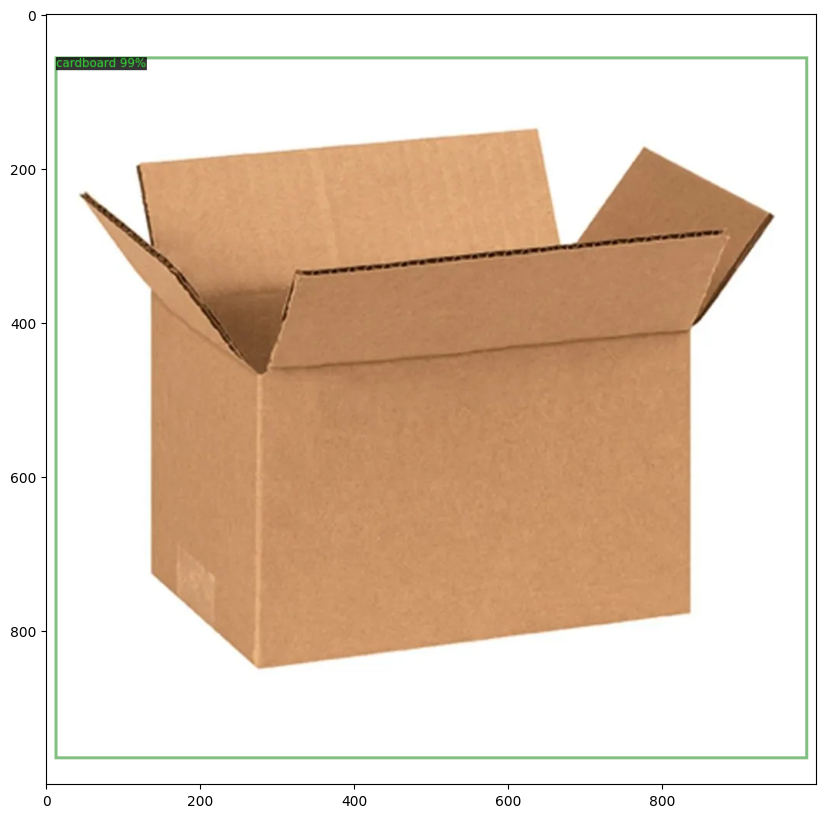

In [403]:
#image outside of the testing set

test = cv2.imread("custom_test_images/box.png")
output = predictor(test)
print(output)
v = Visualizer(test[:, :, ::-1], metadata=test_metadata)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

{'instances': Instances(num_instances=2, image_height=360, image_width=643, fields=[pred_boxes: Boxes(tensor([[ 59.9873,  56.3551, 345.4755, 277.7228],
        [275.4761,  46.9684, 573.2913, 291.3366]], device='cuda:0')), scores: tensor([0.9255, 0.8389], device='cuda:0'), pred_classes: tensor([3, 3], device='cuda:0')])}


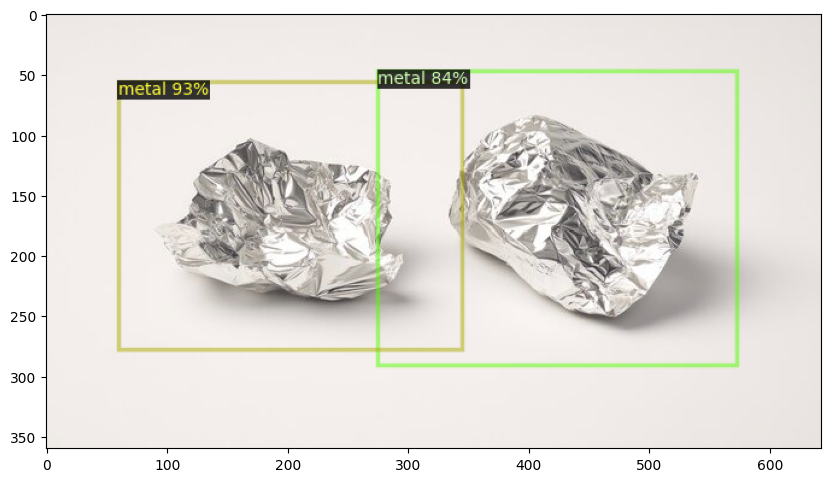

In [394]:
test2 = cv2.imread("custom_test_images/aluminium_foil.jpg")
test2 = cv2.cvtColor(test2, cv2.COLOR_RGB2BGR)
output = predictor(test2)
print(output)
v = Visualizer(test2[:, :, ::-1], metadata=test_metadata)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

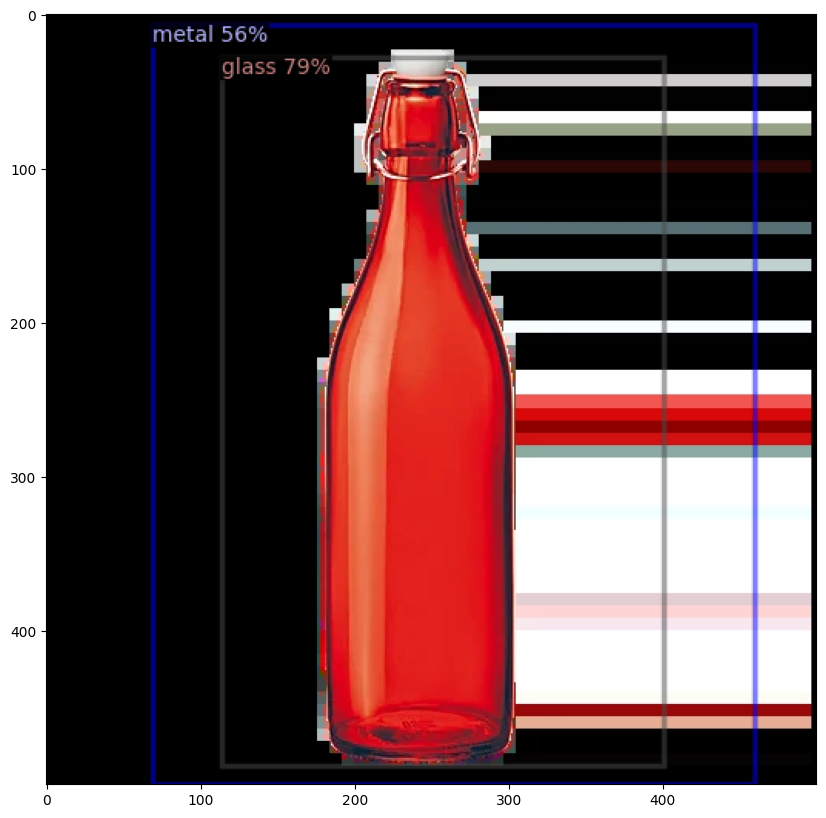

In [405]:
test3 = cv2.imread("custom_test_images/glass_bottle2.png")
output = predictor(test3)
v = Visualizer(test3[:, :, ::-1], metadata=test_metadata)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))